In [23]:
import numpy as np
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from scipy.special import psi
import random
from sklearn.model_selection import train_test_split

In [24]:
torch.use_deterministic_algorithms(True)
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [25]:
num_dim = 100
num_clusters = 10
num_samples_per_cluster = 1000

In [26]:
alpha = (0.1, ) * num_dim

In [27]:
X = np.zeros((num_clusters * num_samples_per_cluster, num_dim))
y = np.zeros((num_clusters * num_samples_per_cluster, ))

In [28]:
for i in range(num_clusters):
    n = math.floor(np.random.uniform(50, 100, 1))
    p = np.random.dirichlet(alpha, 1)[0]
    X[i * num_samples_per_cluster : (i + 1) * num_samples_per_cluster, :] = np.random.multinomial(n, p, size=num_samples_per_cluster)
    y[i * num_samples_per_cluster : (i + 1) * num_samples_per_cluster] = i

In [29]:
X_tensor = torch.tensor(X, dtype=torch.float64)
y_tensor = torch.tensor(y, dtype=torch.int32)

In [30]:
print(X_tensor)

tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [2., 0., 0.,  ..., 1., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [3., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [32]:
dataset_train = torch.utils.data.TensorDataset(X_train, Y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, Y_test)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

In [33]:
class IL(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        eps = 1e-6
        return torch.where(x < 0, (1 / (1 - x)) + eps, x + 1 + eps)

In [34]:
class EL(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.nn.functional.elu(x) + 1

<img src="multinomial_dirichlet_ll.png" alt="Drawing" style="width: 600px;"/>

In [35]:
class AutoEncoderBaseline(nn.Module):
    def __init__(self, num_input=100, num_bottleneck=2):
        super(AutoEncoderBaseline, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_input, 100, dtype=torch.float64),
            nn.ReLU(True),
            nn.Linear(100, 64, dtype=torch.float64),
            nn.ReLU(True), nn.Linear(64, 12, dtype=torch.float64), nn.ReLU(True), nn.Linear(12, num_bottleneck, dtype=torch.float64))
        self.decoder = nn.Sequential(
            nn.Linear(num_bottleneck, 12, dtype=torch.float64),
            nn.ReLU(True),
            nn.Linear(12, 64, dtype=torch.float64),
            nn.ReLU(True),
            nn.Linear(64, 100, dtype=torch.float64),
            nn.ReLU(True), nn.Linear(100, num_input, dtype=torch.float64))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [36]:
class AutoEncoder(nn.Module):
    def __init__(self, num_input=100, num_bottleneck=2):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_input, 64, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(64, 12, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(12, num_bottleneck, dtype=torch.float64)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(num_bottleneck, 12, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(12, 64, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(64, num_input, dtype=torch.float64),
            EL()
        )
        
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [37]:
eps = torch.finfo(torch.float64).eps

In [38]:
def criterion_dirichlet_multinomial(alpha, target):
    """
    Negating the log-likelihood to follow the convention of minimizing the loss function.
    """
    return -(torch.sum(torch.sum(torch.lgamma(alpha + target + eps), dim=1) \
        -  torch.lgamma(torch.sum(alpha + target, dim=1) + eps) \
        +  torch.lgamma(torch.sum(alpha, dim=1) + eps) \
        -  torch.sum(torch.lgamma(alpha + eps), dim=1)))
        
        # The below terms are independent of alpha hence ignored.
        # +  torch.lgamma(torch.sum(target, dim=1)) \
        # -  torch.sum(torch.lgamma(target), dim=1))

In [39]:
def plot_latent(autoencoder, data, label):
    encoded = model.encoder(data).detach().numpy()
    plt.scatter(encoded[:, 0], encoded[:, 1], c=label.detach().numpy())
    plt.colorbar()

In [40]:
batch_size = 100
n_epochs = 100

In [44]:
num_bottleneck = 2
model = AutoEncoderBaseline(num_dim, num_bottleneck)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
for epoch in range(1, n_epochs + 1):
    for i, (data, label) in enumerate(train_loader):
        output = model(data)
        loss = criterion(output, data)
        if i == 0:
            print(f"Epoch {epoch}: loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 1: loss: 7.265616813640536
Epoch 2: loss: 2.537010862912558
Epoch 3: loss: 0.7311736937075937
Epoch 4: loss: 0.6579054589818178
Epoch 5: loss: 0.6496975465195544
Epoch 6: loss: 0.6458451623400846
Epoch 7: loss: 0.6431985238116259
Epoch 8: loss: 0.6363644018285198
Epoch 9: loss: 0.6329409907503275
Epoch 10: loss: 0.6250454244451195
Epoch 11: loss: 0.60922478971637
Epoch 12: loss: 0.6011513437546862
Epoch 13: loss: 0.59651041109806
Epoch 14: loss: 0.5913060708056751
Epoch 15: loss: 0.5863843281944999
Epoch 16: loss: 0.5804430597403516
Epoch 17: loss: 0.5728050856652536
Epoch 18: loss: 0.5647827290868979
Epoch 19: loss: 0.5581903285840337
Epoch 20: loss: 0.5504124101875932
Epoch 21: loss: 0.5405354919826523
Epoch 22: loss: 0.530427814445854
Epoch 23: loss: 0.5217695760618591
Epoch 24: loss: 0.517583861127348
Epoch 25: loss: 0.5136580330941475
Epoch 26: loss: 0.5112767313038232
Epoch 27: loss: 0.5075724211419331
Epoch 28: loss: 0.5065916546272305
Epoch 29: loss: 0.504200290421736
Epo

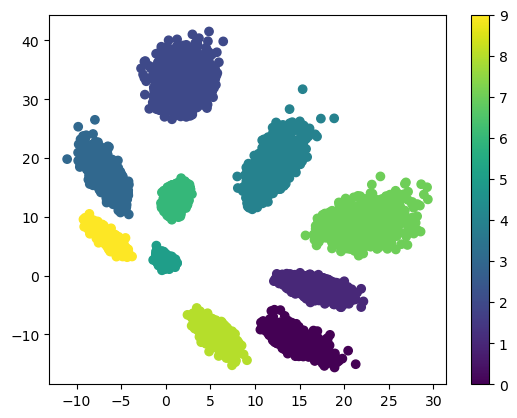

In [46]:
plot_latent(model, X_train, Y_train)

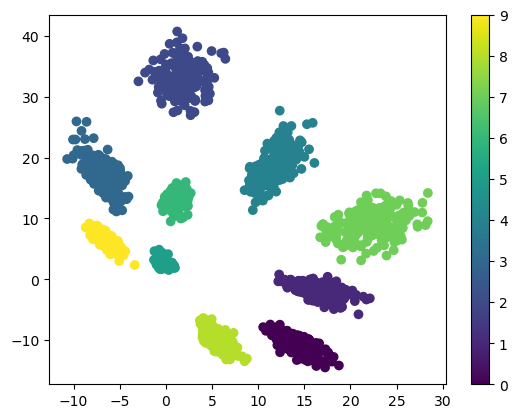

In [47]:
plot_latent(model, X_test, Y_test)

In [31]:
num_bottleneck = 2
model = AutoEncoder(num_dim, num_bottleneck)

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [34]:
for epoch in range(1, n_epochs + 1):
    for i, (data, label) in enumerate(train_loader):        
        alpha = model(data)
        loss = criterion_dirichlet_multinomial(alpha, data)
        if i == 0:
            print(f"Epoch {epoch}: loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 1: loss: 9497.519216229315
Epoch 2: loss: 9015.540928419823
Epoch 3: loss: 8557.465419628781
Epoch 4: loss: 8362.26464134567
Epoch 5: loss: 8292.890473482632
Epoch 6: loss: 8253.825278262339
Epoch 7: loss: 8225.336549916807
Epoch 8: loss: 8194.14232200677
Epoch 9: loss: 8159.756847017508
Epoch 10: loss: 8127.696795060663
Epoch 11: loss: 8096.967500929433
Epoch 12: loss: 8065.170541367121
Epoch 13: loss: 8030.646680470632
Epoch 14: loss: 7992.6483804614045
Epoch 15: loss: 7953.094721929381
Epoch 16: loss: 7914.1394303226325
Epoch 17: loss: 7875.772031287979
Epoch 18: loss: 7837.940969234344
Epoch 19: loss: 7800.729484331549
Epoch 20: loss: 7764.664995391049
Epoch 21: loss: 7729.987721256668
Epoch 22: loss: 7696.603915113827
Epoch 23: loss: 7664.437921128611
Epoch 24: loss: 7633.297654148309
Epoch 25: loss: 7603.48854406825
Epoch 26: loss: 7575.237202865415
Epoch 27: loss: 7548.1927993321315
Epoch 28: loss: 7521.844344167257
Epoch 29: loss: 7496.518339321723
Epoch 30: loss: 7472.40

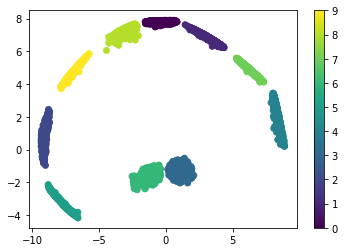

In [35]:
plot_latent(model, X_train, Y_train)

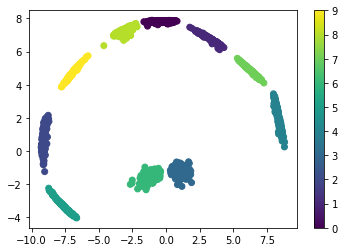

In [36]:
plot_latent(model, X_test, Y_test)